In [1]:
import rasterio
import numpy as np
from rasterio.plot import show
from rasterio.crs import CRS
from rasterio import Affine
from datetime import date

### Create some integrated alert test data

In [2]:
glad_lan = np.zeros((10, 10), dtype=np.uint16)
glad_s2 = np.zeros((10, 10), dtype=np.uint16)
radd = np.zeros((10, 10), dtype=np.uint16)

origin_date = date(2014, 12, 31)

date_glad_lan = date(2019, 2, 23)
date_glad_s2 = date(2021, 7, 20)
date_radd = date(2020, 3, 3)

glad_lan_days = (date_glad_lan - origin_date).days
glad_s2_days = (date_glad_s2 - origin_date).days
radd_days = (date_radd - origin_date).days

glad_lan[1, 1] = 2 * glad_lan_days + 1
glad_lan[2, 2] = 2 * glad_lan_days 

glad_lan[3, 3] = 2 * glad_lan_days + 1
glad_s2[3, 3] = 2 * glad_s2_days

glad_s2[5, 5] = 2 * glad_s2_days
radd[5, 5] = 2 * glad_s2_days

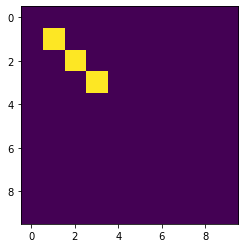

<AxesSubplot:>

In [3]:
show(glad_lan)

### Calc function to generate alert confidence following the rule:
*The integrated confidence level, which is: nominal if only one alert system detected the pixel with low confidence; high if one alert system detected the pixel with high confidence; highest if multiple alert systems detected the pixel.*


In [4]:
low = (np.ma.sum([np.ma.masked_equal(glad_lan, 0) & 1, np.ma.masked_equal(glad_s2, 0) & 1, np.ma.masked_equal(radd, 0) & 1], axis=0) == 1) * 1

high = (np.ma.sum([np.ma.masked_equal(glad_lan, 0) & 1, np.ma.masked_equal(glad_s2, 0) & 1, np.ma.masked_equal(radd, 0) & 1], axis=0) == 0) * 2


highest = ((np.ma.sum([(
        np.ma.masked_equal(glad_lan, 0) > 0) * 1,
        (np.ma.masked_equal(glad_s2, 0) > 0) * 1 ,
        (np.ma.masked_equal(radd, 0) > 0) * 1],
    axis=0) >= 2) * 3).filled(0)


highest_and_high = np.ma.sum([
    ((np.ma.sum([
        (np.ma.masked_equal(glad_lan, 0) > 0) * 1,
        (np.ma.masked_equal(glad_s2, 0) > 0) * 1 ,
        (np.ma.masked_equal(radd, 0) > 0) * 1],
        axis=0) >= 2) *1),
    ((np.ma.sum([
        np.ma.masked_equal(glad_lan, 0) & 1,
        np.ma.masked_equal(glad_s2, 0) & 1,
        np.ma.masked_equal(radd, 0) & 1
    ], axis=0) == 0) * 2)], axis=0)
    

all_conf = np.clip(np.ma.sum([
    (np.ma.sum([
        (np.ma.masked_equal(glad_lan, 0) > 0) * 1,
        (np.ma.masked_equal(glad_s2, 0) > 0) * 1 ,
        (np.ma.masked_equal(radd, 0) > 0) * 1],
        axis=0) >= 2) * 2,
    (np.ma.sum([
        np.ma.masked_equal(glad_lan, 0) & 1,
        np.ma.masked_equal(glad_s2, 0) & 1,
        np.ma.masked_equal(radd, 0) & 1
    ], axis=0) == 0) * 2,
    (np.ma.sum([
        np.ma.masked_equal(glad_lan, 0) & 1,
        np.ma.masked_equal(glad_s2, 0) & 1,
        np.ma.masked_equal(radd, 0) & 1
        ],axis=0) == 1) * 1          
    ], axis=0), None, 3).filled(0)

all_conf

NameError: name 'ma' is not defined

### Save result to file 

In [ ]:
meta = {
    'driver': 'GTiff',
     'dtype': 'uint16',
     'nodata': 0.0,
     'width': 10,
     'height': 10,
     'count': 1,
     'crs': CRS.from_epsg(4326),
     'transform': Affine(0.0001, 0.0, 40.0,
            0.0, -0.0001, -20.0)}

with rasterio.open('integrated_confidence.tif', 'w', **meta) as int_file:
    int_file.write(all_conf, 1)

### Verify data saved correctly

In [ ]:
with rasterio.open('integrated_confidence.tif') as int_file:
    conf_data = int_file.read(1)

### Calc function to get the earliest alert 

In [ ]:
earliest_alert_date = np.ma.min([
        np.ma.masked_equal(glad_lan, 0) >> 1,
        np.ma.masked_equal(glad_s2, 0) >> 1,
        np.ma.masked_equal(radd, 0) >> 1],
    axis=0).filled(0)

earliest_alert_date

### Save alert date to file

In [ ]:
with rasterio.open('earliest_alert.tif', 'w', **meta) as alert_file:
    alert_file.write(earliest_alert_date, 1)